In [1]:
from pynq import Overlay, allocate
import numpy as np
import PIL.Image
import nngen_ctrl as ng

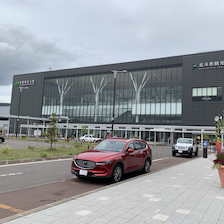

In [2]:
pic = PIL.Image.open('car.png').convert('RGB')
pic

In [3]:
act_shape = (1, 224, 224, 3)
act_scale_factor = 64

imagenet_mean = np.array([0.485, 0.456, 0.406]).astype(np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225]).astype(np.float32)

img = np.array(pic).astype(np.float32)
img = img.reshape([1] + list(img.shape))
img = img / 255
img = (img - imagenet_mean) / imagenet_std

img = img * act_scale_factor
img = np.clip(img, -127.0, 127.0)
img = np.round(img)
img = np.broadcast_to(img, act_shape)

# padding for alignment: (1, 224, 224, 3) -> (1, 224, 224, 4)
input = np.append(img, np.zeros([img.shape[0], img.shape[1], img.shape[2], 1]), axis=3)
input = np.reshape(input, [-1]).astype(np.int8)

param = np.load('vgg11_imagenet.npz')

In [4]:
bitfile = 'vgg11.bit'
ipname = 'vgg11_0'

overlay = Overlay(bitfile)
overlay.ip_dict

{'vgg11_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0x7f8ae52470>,
  'driver': pynq.overlay.DefaultIP,
  'fullpath': 'vgg11_0',
  'gpio': {},
  'interrupts': {},
  'mem_id': 'saxi',
  'parameters': {'C_BASEADDR': '0xA0000000',
   'C_HIGHADDR': '0xA000FFFF',
   'Component_Name': 'design_1_vgg11_0_0',
   'EDK_IPTYPE': 'PERIPHERAL'},
  'phys_addr': 2684354560,
  'registers': {},
  'state': None,
  'type': 'user.org:user:vgg11:1.0'}}

In [5]:
ip = ng.nngen_core(overlay, ipname)

In [6]:
memory_size = 400 * 1024 * 1024
buf = allocate(shape=(memory_size,), dtype=np.uint8)

In [7]:
output_offset = 0
input_offset = 1024
param_offset = 201728

input_wordsize = 1
output_wordsize = 1
param_wordsize = 1
output_length = 1000

output_size = output_length * output_wordsize
input_size = input.size * input_wordsize
param_size = param.size * param_wordsize

buf[input_offset:input_offset + input_size] = input.view(np.uint8)
buf[param_offset:param_offset + param_size] = param.view(np.uint8)

In [8]:
ip.set_global_buffer(buf)

In [9]:
import time
start_time = time.time()

ip.run()
ip.wait()

end_time = time.time()
elapsed_time = end_time - start_time

print(elapsed_time)

9.65985918045044


In [10]:
import json

class_index = json.load(open('imagenet_class_index.json', 'r'))
labels = {int(key): value for (key, value) in class_index.items()}

output = buf[output_offset:output_offset+output_size].view(np.int8)
top10_index = np.argsort(output)[::-1][:10]

for index in top10_index:
    print(index, labels[index], 'score:', output[index])

751 ['n04037443', 'racer'] score: 75
817 ['n04285008', 'sports_car'] score: 70
573 ['n03444034', 'go-kart'] score: 61
705 ['n03895866', 'passenger_car'] score: 60
468 ['n02930766', 'cab'] score: 59
656 ['n03770679', 'minivan'] score: 59
627 ['n03670208', 'limousine'] score: 59
511 ['n03100240', 'convertible'] score: 55
864 ['n04461696', 'tow_truck'] score: 55
436 ['n02814533', 'beach_wagon'] score: 54
